In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [4]:
import os
import shutil

filepath = './dataset'
hand = '/with_mask'
printed = '/without_mask'

In [5]:
count=0
for i in os.listdir(filepath+hand):
    os.rename(filepath+hand+'/'+i,filepath+hand+'/'+'mask'+str(count))
    count=count+1

count=0
for i in os.listdir(filepath+printed):
    os.rename(filepath+printed+'/'+i,filepath+printed+'/'+'unmask'+str(count))
    count=count+1

In [6]:
a = os.listdir(filepath+hand)
a = ['/with_mask/'+ i  for i in a]
b = os.listdir(filepath+printed)
b = ['/without_mask/'+ i for i in b]

In [7]:
data = pd.DataFrame()
data = data.assign(Filename=a+b,Target=[0]*len(a)+[1]*len(b))

In [8]:
data.head()

,Filename,Target
0,/with_mask/mask1825,0
1,/with_mask/mask1632,0
2,/with_mask/mask236,0
3,/with_mask/mask1457,0
4,/with_mask/mask155,0


In [9]:
data.tail()

,Filename,Target
3828,/without_mask/unmask1421,1
3829,/without_mask/unmask1192,1
3830,/without_mask/unmask1016,1
3831,/without_mask/unmask323,1
3832,/without_mask/unmask1533,1


In [10]:
from sklearn.model_selection import train_test_split
X=data['Filename']
y = data['Target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True,random_state=1)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=1,shuffle=True)

len(X_train),len(X_val),len(X_test)

(2452, 614, 767)

In [11]:
import cv2
if os.path.isdir('./train_img') is False:
    os.makedirs('./train_img')
    os.makedirs('./valid_img')
    os.makedirs('./test_img')

    for i in X_train:
        shutil.copy(filepath+i,'./train_img')
    for i in X_val:
        shutil.copy(filepath+i,'./valid_img')
    for i in X_test:
        shutil.copy(filepath+i,'./test_img')

In [12]:
import os
import glob
import shutil
if os.path.isdir('./train_img/mask') is False:
    os.makedirs('./train_img/mask')
    os.makedirs('./train_img/unmask')
    for i in glob.glob('./train_img/ma*'):
        shutil.move(i,'./train_img/mask')
    for i in glob.glob('./train_img/un*'):
        shutil.move(i,'./train_img/unmask')
        
if os.path.isdir('./valid_img/mask') is False:
    os.makedirs('./valid_img/mask')
    os.makedirs('./valid_img/unmask')
    for i in glob.glob('./valid_img/ma*'):
        shutil.move(i,'./valid_img/mask')
    for i in glob.glob('./valid_img/un*'):
        shutil.move(i,'./valid_img/unmask')
        
if os.path.isdir('./test_img/mask') is False:
    os.makedirs('./test_img/mask')
    os.makedirs('./test_img/unmask')
    for i in glob.glob('./test_img/ma*'):
        shutil.move(i,'./test_img/mask')
    for i in glob.glob('./test_img/un*'):
        shutil.move(i,'./test_img/unmask')


In [13]:
import cv2

def image_converter(files):
    image=[]
    for i in files:
        img = cv2.imread(filepath+i,1)
        image.append(cv2.resize(img,(100,100)))
    return image

X_train = np.array(image_converter(X_train))
X_val = np.array(image_converter(X_val))
X_test = np.array(image_converter(X_test))

In [14]:
X_train[0].shape

(100, 100, 3)

In [15]:
len(X_train),len(X_val),len(X_test)

(2452, 614, 767)

In [16]:
# rescale the imagge so that all the pixels lie within 0 and 1
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

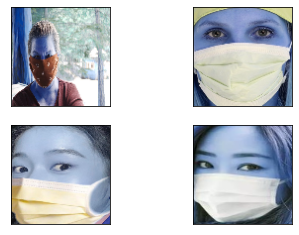

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(2,2,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(X_train[i]))

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy,binary_crossentropy
from tensorflow.keras.applications.vgg16 import VGG16

In [19]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")



In [20]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=[100,100] + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [22]:
model.compile(optimizer='RMSprop',loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
history =model.fit(aug.flow(X_train,y_train,batch_size=20),batch_size=20,epochs=10,verbose=2,validation_data=aug.flow(X_val,y_val,batch_size=20),shuffle=True)

Epoch 1/10
123/123 - 89s - loss: 0.3258 - accuracy: 0.8723 - val_loss: 0.1749 - val_accuracy: 0.9463
Epoch 2/10
123/123 - 93s - loss: 0.1884 - accuracy: 0.9315 - val_loss: 0.1574 - val_accuracy: 0.9397
Epoch 3/10
123/123 - 93s - loss: 0.1535 - accuracy: 0.9462 - val_loss: 0.1297 - val_accuracy: 0.9625
Epoch 4/10
123/123 - 93s - loss: 0.1365 - accuracy: 0.9543 - val_loss: 0.1446 - val_accuracy: 0.9495
Epoch 5/10
123/123 - 93s - loss: 0.1247 - accuracy: 0.9555 - val_loss: 0.1206 - val_accuracy: 0.9544
Epoch 6/10
123/123 - 92s - loss: 0.1116 - accuracy: 0.9637 - val_loss: 0.1131 - val_accuracy: 0.9577
Epoch 7/10
123/123 - 93s - loss: 0.1010 - accuracy: 0.9629 - val_loss: 0.1063 - val_accuracy: 0.9642
Epoch 8/10
123/123 - 93s - loss: 0.0963 - accuracy: 0.9645 - val_loss: 0.0918 - val_accuracy: 0.9674
Epoch 9/10
123/123 - 93s - loss: 0.0975 - accuracy: 0.9629 - val_loss: 0.1079 - val_accuracy: 0.9560
Epoch 10/10
123/123 - 93s - loss: 0.0913 - accuracy: 0.9674 - val_loss: 0.1046 - val_accura

In [25]:
score = model.evaluate(X_test, y_test, verbose=0)
print(score[1])

0.9778357148170471


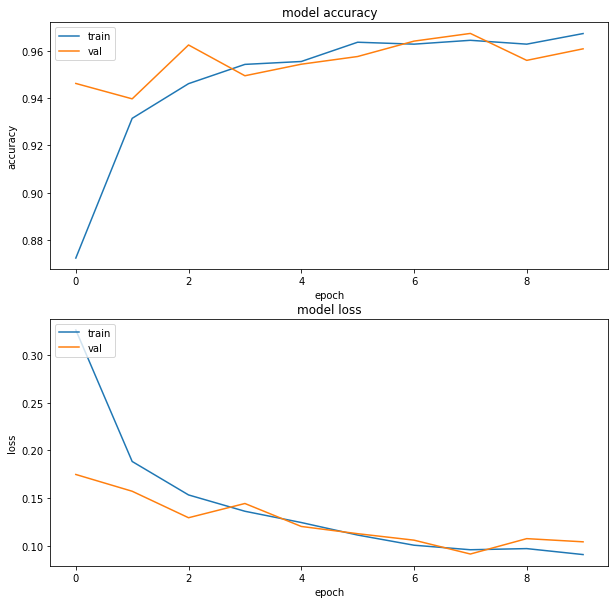

In [26]:
#Finally lets visualize the loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
plt.figure(figsize = (10,10))  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [28]:
import os
if os.path.isfile('train_model.h5') is False:
    model.save('train_model.h5')